In [316]:
import numpy as np
import matplotlib.pyplot as plt

# Read files

In [365]:
import os
contents = [] # [(subject, body, is_spam)]

for path, subdirs, files in os.walk("./data"):
    for name in files:
        with open(os.path.join(path, name), 'r') as f:
            lines = f.readlines()
            subject = lines[0][len("Subject: "):].strip()
            body = lines[2].strip()
            subject_ints = subject
            body_ints = body
            contents.append((subject_ints, body_ints, name.find("spmsg") != -1))
    break # :)

# Prepare data

# Datasets

In [371]:
subj_and_body = contents
no_subj_just_body = [("", body, is_spam) for _, body, is_spam in contents]

# Vectorization

In [372]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words(data):
    cv = CountVectorizer(token_pattern=r"\w+")
    X = []
    Y = []
    for subj, body, is_spam in data:
        X.append(subj + body)
        Y.append(is_spam)
    return cv.fit_transform(X), Y

In [373]:
from sklearn.feature_extraction.text import TfidfVectorizer

def TFIDF(data):
    tv = TfidfVectorizer(token_pattern=r"\w+")
    X = []
    Y = []
    for subj, body, is_spam in data:
        X.append(subj + body)
        Y.append(is_spam)
    return tv.fit_transform(X), Y

# Processed data

In [374]:
subj_and_body_bag = bag_of_words(subj_and_body)
subj_and_body_tfidf = TFIDF(subj_and_body)
no_subj_just_body_bag = bag_of_words(no_subj_just_body)
no_subj_just_body_tfidf = TFIDF(no_subj_just_body)

# Model and prediction

In [375]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

def split(X, Y):
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=1337)
    return train_X, train_Y, test_X, test_Y

def model(train_X, train_Y, **kwargs):
    m = MultinomialNB(**kwargs)
    m.fit(train_X, train_Y)
    return m

def brute_params(f, keys, ranges, i, **kwargs):
    if i >= len(keys):
        return f(**kwargs)
    best_score = 0
    best_m = None
    
    for j in ranges[i]:
        args = dict()
        for x, y in kwargs.items():
            args[x] = y
        args[keys[i]] = j
        m, score = brute_params(f, keys, ranges, i + 1, **args)
        if score > best_score:
            best_score = score
            best_m = m
    return best_m, best_score

def best_model(trainX, trainY, testX, testY, **params):
    def f(**kwargs):
        m = model(trainX, trainY, **kwargs)
        pred = m.predict(testX)
        accuracy = sum(testY[i] == cl for i, cl in enumerate(pred)) / len(testY)
        return m, accuracy
    return brute_params(f, list(params.keys()), list(params.values()), 0)


# Get best AUC

In [376]:
from sklearn.metrics import roc_curve, auc

def roc_auc_score(actual, proba):
    fpr, tpr, _ = roc_curve(actual, proba)
    return fpr, tpr, auc(fpr, tpr)

def draw_roc(fpr, tpr, auc_score):
    plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % auc_score)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [377]:
data = {
    "subject + body, bag of words": subj_and_body_bag,
    "subject + body, TFIDF": subj_and_body_tfidf,
    "no subject, just body, bag of words": no_subj_just_body_bag,
    "no subject, just body, TFIDF": no_subj_just_body_tfidf,
}

In [378]:
best = None
best_auc = 0

for name, xy in data.items():
    trainX, trainY, testX, testY = split(*xy)
    m, acc = best_model(trainX, trainY, testX, testY, alpha=np.linspace(0.01, 5, 20))
    fpr, tpr, auc_score = roc_auc_score(testY, m.predict_proba(testX)[:, 1])
    if auc_score > best_auc:
        best_auc = auc_score
        best = (name, m, acc, fpr, tpr)

best try: name="subject + body, TFIDF", auc=0.999654934437543, accuracy=0.9862385321100917


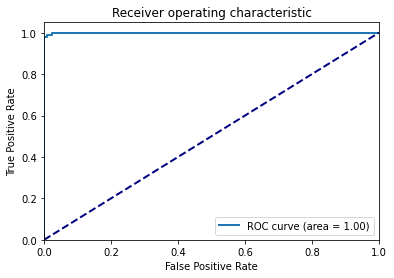

In [379]:
print("best try: name=\"{0}\", auc={1}, accuracy={2}".format(best[0], best_auc, best[2]))
draw_roc(best[3], best[4], best_auc)

In [380]:
best[1].alpha

0.01

# Accuracy and aprior proba

In [381]:
class_prior = [[1-p, p] for p in np.logspace(-15, -1, 15)]

In [383]:
accuracies = []
trainX, trainY, testX, testY = split(*data["subject + body, TFIDF"])

for i in class_prior:
    m = model(trainX, trainY, alpha=0.01, class_prior=i)
    pred = m.predict(testX)
    accuracy = sum(testY[i] == cl for i, cl in enumerate(pred)) / len(testY)
    accuracies.append(accuracy)

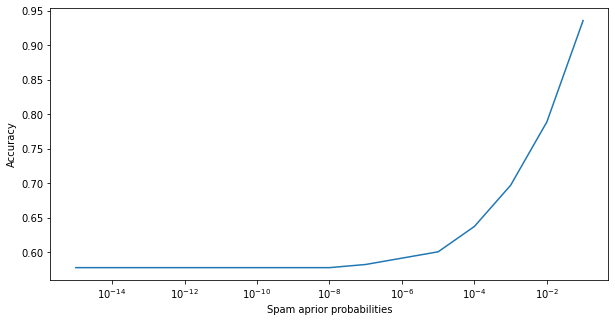

In [384]:
plt.figure(figsize=(10, 5))
plt.plot(np.logspace(-15, -1, 15), accuracies)
plt.xlabel("Spam aprior probabilities")
plt.ylabel("Accuracy")
plt.xscale('log')
plt.show()

# Make no false positives

In [426]:
alpha = np.linspace(1e-8, 3, 10)
class_prior = [[1-p, p] for p in np.linspace(1e-20, 1e-5, 150)]

In [427]:
best = None
best_acc = 0

for name, xy in data.items():
    trainX, trainY, testX, testY = split(*xy)
    m, acc = best_model(trainX, trainY, testX, testY, alpha=alpha, class_prior=class_prior)
    pred = m.predict(testX)
    if any(pred[i] and not actual for i, actual in enumerate(testY)):
        continue # has false positives
    if acc > best_acc:
        best_acc = acc
        fpr, tpr, auc_score = roc_auc_score(testY, m.predict_proba(testX)[:, 1])
        best = (name, m, auc_score, fpr, tpr)

best try: name="subject + body, TFIDF", auc=0.995600414078675, accuracy=0.7798165137614679


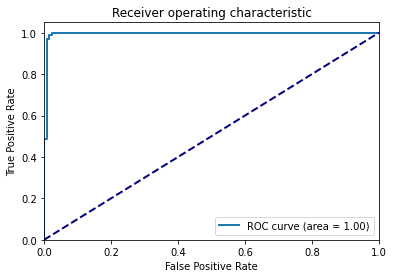

In [428]:
print("best try: name=\"{0}\", auc={1}, accuracy={2}".format(best[0], best[2], best_acc))
draw_roc(best[3], best[4], best[2])

In [429]:
best[1].alpha, best[1].class_prior

(1e-08, [0.9999938926174496, 6.107382550335575e-06])